The following is our initial draft. We are looking to add more maps and analysis, and improve our ML models. However, we would like any comments or suggestions if any. 

# Part 1: Obtaining and Organizing Data

Using Socrata, we imported two datasets using the New York City Open Data Portal APIs. It included a dataset of property valuations in New York City, and another dataset listing the reassesment actions. App_tokens were used to adjust limits for valuation results and testing our code on smaller/larger datasets. 

In [1]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
client = Socrata("data.cityofnewyork.us", '9llM0ejMVTKfRxS1XlvL7gXjU')

#first one is the property valuation and assessment dataset
vresults = client.get("yjxr-fw8i", content_type='geojson', year = '2017/18', limit=10000000)

#second one is the assessment actions dataset
aresults = client.get("4nft-bihw", content_type='json', limit=100000) 

In [3]:
value_gdf = gpd.GeoDataFrame.from_features(vresults, crs='EPSG:4326')
actions_df = pd.DataFrame.from_records(aresults)

Dropping properties in reassessment dataset with no actual reassessments, and dropping properties from valuation dataset that do not actually have values.

In [4]:
len(actions_df)

12321

In [5]:
actions_df['granted_reduction_amount']=pd.to_numeric(actions_df['granted_reduction_amount'])
actions_df=actions_df[actions_df['granted_reduction_amount']>0]
len(actions_df)

11773

In [143]:
actions_df.sort_values('granted_reduction_amount', ascending=False).head()

borough_code block_number lot_number tax_year  \
BBB                                                       
1-972-1              1          972          1     2018   
1-1266-1             1         1266          1     2018   
1-1294-1             1         1294          1     2018   
1-41-1301            1           41       1301     2018   
1-815-26             1          815         26     2018   

                      owner_name       property_address  \
BBB                                                       
1-972-1         BPP ST OWNER LLC           240 1 AVENUE   
1-1266-1   RCPI LANDMARK PROPERT  1260 AVENUE OF THE AM   
1-1294-1   767 FIFTH PARTNERS LL           761 5 AVENUE   
1-41-1301  EBRA 70 PINE MASTER T         66 PINE STREET   
1-815-26          7BP OWNER, LLC  1045 AVENUE OF THE AM   

           granted_reduction_amount tax_class_code        BBB  
BBB                                                            
1-972-1                  98502400.0              2    1-972-1  
1-1266-1                 60742800.0              4   1-1266-1  
1-1294-1                 50364900.0              4   1-1294-1  
1-41-1301                41959000.0              2  1-41-1301  
1-815-26                 37321000.0              4   1-815-26

In [6]:
len(value_gdf)

1110058

In [7]:
value_gdf['avtot']=pd.to_numeric(value_gdf['avtot'])
value_gdf=value_gdf[value_gdf['avtot']>0]
len(value_gdf)

1094727

In order to combine the valuation and assessment datasets, a new column was made that combines the borough, block, and lot numbers (keeping it as a string).

In [8]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
value_gdf['BBB']

actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df['BBB']

actions_df.set_index('BBB', inplace=True)
value_gdf.set_index('BBB', inplace=True)

Trying to figure out what to drop in order to get clean data with no repeats

In [135]:
actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df[actions_df.duplicated('BBB')]

borough_code block_number lot_number tax_year  \
BBB                                                          
1-7-29                  1            7         29     2018   
1-7-30                  1            7         30     2018   
1-7-33                  1            7         33     2018   
1-7-35                  1            7         35     2018   
1-7-37                  1            7         37     2018   
1-16-1301               1           16       1301     2018   
1-16-8001               1           16       8001     2018   
1-18-1002               1           18       1002     2018   
1-20-13                 1           20         13     2018   
1-29-1101               1           29       1101     2018   
1-29-1201               1           29       1201     2018   
1-31-1                  1           31          1     2018   
1-41-1301               1           41       1301     2018   
1-42-1                  1           42          1     2018   
1-44-1                  1           44          1     2018   
1-47-1001               1           47       1001     2018   
1-56-1                  1           56          1     2018   
1-62-1001               1           62       1001     2018   
1-64-1003               1           64       1003     2018   
1-68-36                 1           68         36     2018   
1-69-32                 1           69         32     2018   
1-69-1102               1           69       1102     2018   
1-72-25                 1           72         25     2018   
1-72-1001               1           72       1001     2018   
1-72-1002               1           72       1002     2018   
1-75-1011               1           75       1011     2018   
1-78-1201               1           78       1201     2018   
1-78-1602               1           78       1602     2018   
1-113-1005              1          113       1005     2018   
1-125-20                1          125         20     2018   
1-126-27                1          126         27     2018   
1-133-2001              1          133       2001     2018   
1-135-1001              1          135       1001     2018   
1-135-1301              1          135       1301     2018   
1-140-1006              1          140       1006     2018   
1-142-1101              1          142       1101     2018   
1-146-23                1          146         23     2018   
1-150-31                1          150         31     2018   
1-151-28                1          151         28     2018   
1-151-32                1          151         32     2018   
1-164-58                1          164         58     2018   
1-170-1                 1          170          1     2018   
1-172-1209              1          172       1209     2018   
1-173-31                1          173         31     2018   
1-187-16                1          187         16     2018   
1-195-6                 1          195          6     2018   
1-195-27                1          195         27     2018   
1-201-14                1          201         14     2018   
1-203-31                1          203         31     2018   
1-204-33                1          204         33     2018   
1-208-1002              1          208       1002     2018   
1-209-32                1          209         32     2018   
1-210-19                1          210         19     2018   
1-210-1001              1          210       1001     2018   
1-212-1002              1          212       1002     2018   
1-212-1004              1          212       1004     2018   
1-214-3                 1          214          3     2018   
1-218-1170              1          218       1170     2018   
1-219-1002              1          219       1002     2018   
1-219-1302              1          219       1302     2018   
1-230-4                 1          230          4     2018   
1-233-2                 1          233          2     2018   
1-274-1103              1          274       

In [137]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
len(value_gdf[value_gdf.duplicated('BBB')])

1585

We then conducted an inner join, so that each property reassessment had linked with its valuation.

In [9]:
inner_joined_gdf = value_gdf.join(actions_df, how='inner', rsuffix=('_actions'))

And then creating a new column that shows the percent reduction

In [10]:
#making them numeric first
inner_joined_gdf['granted_reduction_amount']=pd.to_numeric(inner_joined_gdf['granted_reduction_amount'])
inner_joined_gdf['avtot']=pd.to_numeric(inner_joined_gdf['avtot'])

#making the new column
inner_joined_gdf['reduction_scaled']=inner_joined_gdf['granted_reduction_amount']/inner_joined_gdf['avtot']

print(len(inner_joined_gdf))
inner_joined_gdf.head()

11722


geometry                                nta  \
BBB                                                                         
1-10-14     POINT (-74.01304 40.70331)  Battery Park City-Lower Manhattan   
1-10-15     POINT (-74.01309 40.70352)  Battery Park City-Lower Manhattan   
1-10-33     POINT (-74.01264 40.70403)  Battery Park City-Lower Manhattan   
1-100-1001  POINT (-74.00603 40.71154)  Battery Park City-Lower Manhattan   
1-100-1201  POINT (-74.00540 40.71124)  Battery Park City-Lower Manhattan   

             avland   latitude    zip stories      avtot easement valtype  \
BBB                                                                         
1-10-14     7875000  40.703312  10004      30   38897100     None   AC-TR   
1-10-15      406800  40.703517  10004       7    1720350     None   AC-TR   
1-10-33     3690450  40.704025  10004      43   35656200     None   AC-TR   
1-100-1001    65790  40.711541  10038      23    1183950     None   AC-TR   
1-100-1201  5841450  40.711245  10038      76  140023350     None   AC-TR   

             exland  ... ltdepth borough_code block_number lot_number  \
BBB                  ...                                                
1-10-14           0  ...     161            1           10         14   
1-10-15           0  ...      58            1           10         15   
1-10-33           0  ...     125            1           10         33   
1-100-1001        0  ...       0            1          100       1001   
1-100-1201  2759170  ...       0            1          100       1201   

           tax_year             owner_name     property_address  \
BBB                                                               
1-10-14        2018  BROAD FINANCIAL CENTE  33 WHITEHALL STREET   
1-10-15        2018          MSA TWINS LTD  27 WHITEHALL STREET   
1-10-33        2018  AL STONE GROUND TENAN       8 STONE STREET   
1-100-1001     2018   THE BRAUSER GROUP #1    150 NASSAU STREET   
1-100-1201     2018  FC 8 SPRUCE STREET RE      8 SPRUCE STREET   

           granted_reduction_amount tax_class_code reduction_scaled  
BBB                                                                  
1-10-14                   1755500.0              4         0.045132  
1-10-15                     92350.0              4         0.053681  
1-10-33                   2158050.0              4         0.060524  
1-100-1001                 247400.0              4         0.208962  
1-100-1201                3949350.0              2         0.028205  

[5 rows x 49 columns]

In [11]:
print(len(inner_joined_gdf[inner_joined_gdf['reduction_scaled']==float('inf')]))

0


In [12]:
print(len(inner_joined_gdf[inner_joined_gdf['reduction_scaled']==0]))

0


In [13]:
print(len(inner_joined_gdf[inner_joined_gdf['reduction_scaled']>1]))

58


In [14]:
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
inner_joined_gdf[inner_joined_gdf['reduction_scaled']>1]

geometry  \
BBB                                       
1-1722-63    POINT (-73.94446 40.80733)   
1-203-23     POINT (-73.99569 40.71687)   
1-276-1103   POINT (-73.99591 40.71144)   
1-44-1                             None   
1-44-1                             None   
1-595-1201   POINT (-74.01018 40.72437)   
1-788-71     POINT (-73.98966 40.75468)   
2-2597-1                           None   
2-2597-1                           None   
2-3298-16    POINT (-73.88556 40.87124)   
2-3937-1001                        None   
2-3938-1001                        None   
2-5380-1     POINT (-73.84051 40.84072)   
3-2061-1104  POINT (-73.98086 40.69354)   
3-208-331                          None   
3-208-506                          None   
3-208-506                          None   
3-2279-34    POINT (-73.95638 40.72254)   
3-252-1                            None   
3-252-8                            None   
3-252-8                            None   
3-3590-16                          None   
3-556-111    POINT (-74.01117 40.67804)   
3-556-113    POINT (-74.01108 40.67797)   
3-556-115    POINT (-74.01103 40.67794)   
3-556-146    POINT (-74.01178 40.67752)   
3-556-147    POINT (-74.01178 40.67752)   
3-556-148    POINT (-74.01183 40.67755)   
3-556-149    POINT (-74.01188 40.67759)   
3-556-15     POINT (-74.01122 40.67807)   
3-556-150    POINT (-74.01193 40.67762)   
3-583-28     POINT (-74.00065 40.67252)   
3-8411-1     POINT (-73.90826 40.61967)   
3-874-68     POINT (-73.98839 40.66106)   
4-10592-150                        None   
4-10592-150                        None   
4-15628-50   POINT (-73.74998 40.59937)   
4-15784-1    POINT (-73.75799 40.59538)   
4-362-17     POINT (-73.93986 40.75941)   
4-397-29     POINT (-73.93569 40.75346)   
4-4363-100                         None   
4-5027-1125  POINT (-73.81819 40.76267)   
4-5040-17    POINT (-73.83282 40.75578)   
4-516-109    POINT (-73.93098 40.76955)   
5-1760-110                         None   
5-1760-200                         None   
5-327-15                           None   
5-5533-58                          None   
5-5533-62                          None   
5-5965-84                          None   
5-6025-35                          None   
5-6025-35                          None   
5-7067-166                         None   
5-7071-34                          None   
5-7469-170                         None   
5-7469-170                         None   
5-7469-200                         None   
5-7469-200                         None   

                                                        nta   avland  \
BBB                                                                    
1-1722-63                              Central Harlem South   104400   
1-203-23             SoHo-TriBeCa-Civic Center-Little Italy   203400   
1-276-1103                                        Chinatown     6103   
1-44-1                                                 None  4158000   
1-44-1                                                 None  4158000   
1-595-1201           SoHo-TriBeCa-Civic Center-Little Italy   135000   
1-788-71                              Midtown-Midtown South   284400   
2-2597-1                                               None     4500   
2-2597-1                                               None     3150   
2-3298-16                        Bedford Park-Fordham North   173250   
2-3937-1001                                            None    10759   
2-3938-1001                                            None     2045   
2-5380-1            Van Nest-Morris Park-Westchester Square    90900   
3-2061-1104                                     Fort Greene    19982   
3-208-331                                              None      450   
3-208-506                                              None     3600   
3-208-506                                              None     3600   
3-2279-34                             North Side-South Side   422100   
3-252-1   

In [15]:
inner_joined_gdf[inner_joined_gdf['exmptcl']=='X1']

geometry  \
BBB                                       
1-1084-1     POINT (-73.99203 40.76943)   
1-1118-52    POINT (-73.98028 40.77305)   
1-1214-10    POINT (-73.97516 40.78520)   
1-1214-10    POINT (-73.97516 40.78520)   
1-1220-1     POINT (-73.97353 40.78971)   
1-1226-29    POINT (-73.96795 40.79229)   
1-1746-21    POINT (-73.94336 40.80201)   
1-1775-28    POINT (-73.93638 40.80483)   
1-181-20     POINT (-74.00915 40.71933)   
1-1846-3     POINT (-73.95945 40.80142)   
1-1846-3     POINT (-73.95945 40.80142)   
1-44-1                             None   
1-44-1                             None   
1-493-41     POINT (-73.99481 40.72136)   
1-785-23     POINT (-73.99120 40.75212)   
1-798-41     POINT (-73.99319 40.74240)   
1-847-33     POINT (-73.98967 40.73762)   
1-847-40     POINT (-73.98875 40.73788)   
2-2597-1     POINT (-73.90660 40.80173)   
2-2597-1                           None   
2-3576-1     POINT (-73.84226 40.82127)   
2-3576-1     POINT (-73.84226 40.82127)   
2-3830-44    POINT (-73.84501 40.83311)   
3-208-331                          None   
3-208-506                          None   
3-208-506                          None   
3-239-1      POINT (-73.99189 40.69490)   
3-239-1      POINT (-73.99189 40.69490)   
3-252-1                            None   
3-252-8                            None   
3-252-8                            None   
3-2666-101   POINT (-73.93800 40.72834)   
3-2819-8     POINT (-73.93688 40.72267)   
3-2988-25    POINT (-73.92476 40.70986)   
3-3590-16                          None   
3-3617-25    POINT (-73.90513 40.65899)   
3-625-65     POINT (-73.99635 40.66811)   
3-6997-117   POINT (-73.98386 40.58225)   
3-7920-20    POINT (-73.91706 40.64172)   
3-874-68     POINT (-73.98839 40.66106)   
4-10100-1    POINT (-73.80003 40.70340)   
4-10155-1    POINT (-73.79474 40.70551)   
4-10155-1    POINT (-73.79474 40.70551)   
4-10592-150                        None   
4-10592-150                        None   
4-1937-1     POINT (-73.86005 40.73974)   
4-4138-1     POINT (-73.83602 40.78166)   
4-4138-1     POINT (-73.83602 40.78166)   
4-4143-1     POINT (-73.83365 40.78166)   
4-4143-1     POINT (-73.83365 40.78166)   
4-4273-40    POINT (-73.84045 40.77651)   
4-4363-100                         None   
4-4404-1                           None   
4-4404-1                           None   
4-705-1      POINT (-73.91746 40.75387)   
4-705-24     POINT (-73.91617 40.75432)   
5-1760-110                         None   
5-1760-200                         None   
5-327-15                           None   
5-3327-52    POINT (-74.08720 40.59269)   
5-503-32     POINT (-74.07516 40.63368)   
5-5533-58                          None   
5-5965-84                          None   
5-5965-84    POINT (-74.19824 40.55939)   
5-6025-35                          None   
5-6025-35                          None   
5-7071-34                          None   
5-7469-170                         None   
5-7469-170                         None   
5-7469-200                         None   
5-7469-200                         None   

                                                         nta   avland  \
BBB                                                                     
1-1084-1                                             Clinton  3614850   
1-1118-52                                     Lincoln Square  2250450   
1-1214-10                                    Upper West Side   720000   
1-1214-10                                    Upper West Side   720000   
1-1220-1                                     Upper West Side  5850000   
1-1226-29                                    Upper West Side  7740000   
1-1746-21                                  East Harlem North   675000   
1-1775-28                                  East Harlem North   270000   
1-181-20              SoHo-TriBeCa-Civic Center-Little Italy   161100   
1-1846-3                                Central Harlem South   180000   
1-1846-3       

In [46]:
inner_joined_gdf[inner_joined_gdf['granted_reduction_amount']>1000000].head()

geometry                                nta  \
BBB                                                                         
1-10-14     POINT (-74.01304 40.70331)  Battery Park City-Lower Manhattan   
1-10-33     POINT (-74.01264 40.70403)  Battery Park City-Lower Manhattan   
1-100-1201  POINT (-74.00540 40.71124)  Battery Park City-Lower Manhattan   
1-1000-29   POINT (-73.98154 40.75839)              Midtown-Midtown South   
1-1000-62   POINT (-73.98426 40.75969)              Midtown-Midtown South   

               avland   latitude    zip stories      avtot easement valtype  \
BBB                                                                           
1-10-14       7875000  40.703312  10004      30   38897100     None   AC-TR   
1-10-33       3690450  40.704025  10004      43   35656200     None   AC-TR   
1-100-1201    5841450  40.711245  10038      76  140023350     None   AC-TR   
1-1000-29   134548200  40.758393  10036      45  398219850     None   AC-TR   
1-1000-62     1575000  40.759694  10036       4    8193150     None   AC-TR   

             exland blddepth     year taxclass   longitude bldfront bldgcl  \
BBB                                                                          
1-10-14           0      160  2017/18        4  -74.013038       58     O4   
1-10-33           0      125  2017/18        4  -74.012638       71     H2   
1-100-1201  2759170        0  2017/18        2  -74.005396        0     RR   
1-1000-29         0      421  2017/18        4  -73.981537      188     O4   
1-1000-62         0       69  2017/18        4  -73.984265       25     K4   

           block     avtot2 excd1        bble                   staddr  \
BBB                                                                      
1-10-14       10   37711690  None  1000100014      33 WHITEHALL STREET   
1-10-33       10   31040240  None  1000100033           8 STONE STREET   
1-100-1201   100  111857319  5116  1001001201          8 SPRUCE STREET   
1-1000-29   1000  356064118  1985  1010000029  1211 AVENUE OF THE AMER   
1-1000-62   1000    6393990  None  1010000062             717 7 AVENUE   

           exmptcl    avland2 census_tract   lot boro ltfront    fullval  \
BBB                                                                        
1-10-14       None    7875000            9    14    1      82   86438000   
1-10-33       None    3690450            9    33    1      71   79236000   
1-100-1201    None    5841450         1501  1201    1       0  311163000   
1-1000-29     None  134549280          125    29    1     200  884933000   
1-1000-62     None    1575000          125    62    1      25   18207000   

             ext      bin excd2                  owner      extot     extot2  \
BBB                                                                            
1-10-14     None  1000023  None  BROAD FINANCIAL CENTE          0       None   
1-10-33     None  1087618  None  B.H. 8 STONE STREET C          0       None   
1-100-1201  None  1087485  None  FC 8 SPRUCE STREET RE  136941070  108775039   
1-1000-29      G  1022678  None  1211 6TH AVENUE SYNDI   25672320   25672320   
1-1000-62      E  1022686  None  MOORE, DOLORITA F/B/O          0       None   

            exland2 community_board    borough period council_district  \
BBB                                                                      
1-10-14        None             101  MANHATTAN  FINAL                1   
1-10-33        None             101  MANHATTAN  FINAL                1   
1-100-1201  2759170             101  MANHATTAN  FINAL                1   
1-1000-29      None             105  MANHATTAN  FINAL                4   
1-1000-62      None             105  MANHATTAN  FINAL                4   

           ltdepth borough_code block_number lot_number tax_year  \
BBB                                                                
1-10-14        161            1           10         14     2018   
1-10-33        125            1           10         

In [17]:
actions_df_2017=actions_df[actions_df['tax_year']=='2017']
actions_df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2253 entries, 1-7-29 to 5-72830-5
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   borough_code              2253 non-null   object 
 1   block_number              2253 non-null   object 
 2   lot_number                2253 non-null   object 
 3   tax_year                  2253 non-null   object 
 4   owner_name                2253 non-null   object 
 5   property_address          2227 non-null   object 
 6   granted_reduction_amount  2253 non-null   float64
 7   tax_class_code            2253 non-null   object 
dtypes: float64(1), object(7)
memory usage: 158.4+ KB


In [18]:
actions_df_2018=actions_df[actions_df['tax_year']=='2018']
actions_df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9520 entries, 1-7-29 to 5-72830-5
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   borough_code              9520 non-null   object 
 1   block_number              9520 non-null   object 
 2   lot_number                9520 non-null   object 
 3   tax_year                  9520 non-null   object 
 4   owner_name                9520 non-null   object 
 5   property_address          9473 non-null   object 
 6   granted_reduction_amount  9520 non-null   float64
 7   tax_class_code            9520 non-null   object 
dtypes: float64(1), object(7)
memory usage: 669.4+ KB


# Part 1.5: Obtaining and Organizing Census Data

We looked to analyze our datasets with connection to Census Tract information. We imported demographic information using Cenpy, and obtained it by County rather than the whole city due to mapping issues

In [19]:
from cenpy import products

def borough_census(borough):
    df=products.ACS(2017).from_county(borough+', NY', level='tract',
                                        variables=['B19019_001E', 'B01003_001E', '^B02001', 'B03003_003E', 'B25003_001E', 'B25003_002E', 'B25003_003E', 'B09001_001E', 'B01002_001E'])
    df.rename(columns={'B19019_001E':'median_HH_income', 'B01003_001E':'total_population', 'B02001_001E':'total_population_race','B02001_002E':'total_white'}, inplace=True)
    df.rename(columns={'B02001_003E':'total_black', 'B02001_004E':'total_americanindian', 'B02001_005E':'total_asian','B02001_006E':'total_hawaiian'}, inplace=True)
    df.rename(columns={'B02001_007E':'total_otherrace', 'B02001_008E':'total_twoplusraces', 'B03003_003E':'total_hisp_latino','B09001_001E':'pop_under18','B01002_001E':'median_age'}, inplace=True)
    df.drop(columns=['total_population_race', 'B02001_009E', 'B02001_010E'], inplace=True)
    df['pct_renter'] = df['B25003_003E']/df['B25003_001E']*100
    return df

In [20]:
#getting census data for each borough
manhattandf=borough_census('New York County')
brooklyndf=borough_census('King County')
bronxdf=borough_census('Bronx County')
queensdf=borough_census('Queens County')
statendf=borough_census('Richmond County')

boroughdfs=[manhattandf, brooklyndf, bronxdf, queensdf, statendf]
censusGdf=pd.concat(boroughdfs)
censusGdf.drop(columns=['B25003_001E', 'B25003_002E',
       'B25003_003E', 'NAME', 'state'], inplace=True)

/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

In [21]:
sjoindf = censusGdf.to_crs("EPSG:3857").sjoin(inner_joined_gdf.to_crs("EPSG:3857"),how='left')
sjoindf.head()

GEOID                                           geometry  median_age  \
0  36061031900  POLYGON ((-8240500.560 4968891.470, -8239842.1...         NaN   
1  36061006900  POLYGON ((-8239939.840 4972655.360, -8239911.7...        35.2   
1  36061006900  POLYGON ((-8239939.840 4972655.360, -8239911.7...        35.2   
1  36061006900  POLYGON ((-8239939.840 4972655.360, -8239911.7...        35.2   
1  36061006900  POLYGON ((-8239939.840 4972655.360, -8239911.7...        35.2   

   total_population  total_white  total_black  total_americanindian  \
0               0.0          0.0          0.0                   0.0   
1            2568.0       2037.0         53.0                   0.0   
1            2568.0       2037.0         53.0                   0.0   
1            2568.0       2037.0         53.0                   0.0   
1            2568.0       2037.0         53.0                   0.0   

   total_asian  total_hawaiian  total_otherrace  total_twoplusraces  \
0          0.0             0.0              0.0                 0.0   
1        293.0             0.0             57.0               128.0   
1        293.0             0.0             57.0               128.0   
1        293.0             0.0             57.0               128.0   
1        293.0             0.0             57.0               128.0   

   total_hisp_latino  pop_under18  median_HH_income county   tract  \
0                0.0          0.0               NaN    061  031900   
1              161.0        341.0          198636.0    061  006900   
1              161.0        341.0          198636.0    061  006900   
1              161.0        341.0          198636.0    061  006900   
1              161.0        341.0          198636.0    061  006900   

   pct_renter index_right           nta   avland   latitude    zip stories  \
0         NaN         NaN           NaN      NaN        NaN    NaN     NaN   
1   60.673235  1-601-1201  West Village    84279  40.729588  10014       6   
1   60.673235    1-601-52  West Village   517500  40.730268  10014       9   
1   60.673235    1-602-10  West Village  2908350  40.730545  10014       6   
1   60.673235    1-602-30  West Village  1170000  40.730614  10014       5   

        avtot easement valtype exland blddepth     year taxclass   longitude  \
0         NaN      NaN     NaN    NaN      NaN      NaN      NaN         NaN   
1    274500.0     None   AC-TR      0        0  2017/18        4  -74.007887   
1   7767450.0     None   AC-TR      0      100  2017/18        4  -74.007393   
1  20442600.0     None   AC-TR      0       99  2017/18        2   -74.00906   
1   7667550.0     None   AC-TR  31920       93  2017/18        2  -74.009024   

  bldfront bldgcl block    avtot2 excd1        bble                 staddr  \
0      NaN    NaN   NaN       NaN   NaN         NaN                    NaN   
1        0     RK   601    215330  None  1006011201     43 CLARKSON STREET   
1       75     O6   601   6476580  None  1006010052       110 LEROY STREET   
1      200     D6   602  16258770  None  1006020010  600 WASHINGTON STREET   
1       20     D4   602   6450110  1017  1006020030  603 WASHINGTON STREET   

  exmptcl  avland2 census_tract   lot boro ltfront   fullval   ext      bin  \
0     NaN      NaN          NaN   NaN  NaN     NaN       NaN   NaN      NaN   
1    None    84279           69  1201    1       0    610000  None  1010392   
1    None   517500           69    52    1      75  17261000  None  1010394   
1    None  2897010           69    10    1     199  45428000  None  1086101   
1    None  1170000           69    30    1      93  17039000  None  1078097   

  excd2                  owner  extot extot2 exland2 community_board  \
0   NaN                    NaN    NaN    NaN     NaN             NaN   
1  None  43 CLARKSON STREET LL      0   None    None             102   
1  None  ROYALTON REALTY ASSOC      0   None    None             102   
1  None  EQR-600 WASHINGTON, L      0   None    None             

In [22]:
#making a new df with the total reduction amount granted per tract and joining it to census df
reductionpertract = sjoindf.groupby('tract')[['granted_reduction_amount']].sum()
reductionpertract.rename(columns={'granted_reduction_amount':'total_tract_reduction'}, inplace=True)
censusjoined = censusGdf.join(reductionpertract, on='tract')

In [23]:
#making a new df with the total number of reductions per tract
#adding another column for the total number of property reductions in a census tract
numberreductions = sjoindf.groupby('tract')[['tract']].count()
numberreductions.rename(columns={'tract':'number_reductions'}, inplace=True)
censusjoined = censusjoined.join(numberreductions, on='tract')
censusjoined.head()

GEOID                                           geometry  median_age  \
0  36061031900  POLYGON ((-8240500.560 4968891.470, -8239842.1...         NaN   
1  36061006900  POLYGON ((-8239939.840 4972655.360, -8239911.7...        35.2   
2  36061010300  POLYGON ((-8237738.160 4975861.700, -8237700.9...        33.6   
3  36061008700  POLYGON ((-8237672.930 4974484.150, -8237645.8...        35.8   
4  36061011100  POLYGON ((-8237493.260 4976308.140, -8237467.7...        33.4   

   total_population  total_white  total_black  total_americanindian  \
0               0.0          0.0          0.0                   0.0   
1            2568.0       2037.0         53.0                   0.0   
2            1674.0       1130.0         90.0                   4.0   
3            6815.0       5493.0         85.0                   0.0   
4            5012.0       3111.0        367.0                   0.0   

   total_asian  total_hawaiian  total_otherrace  total_twoplusraces  \
0          0.0             0.0              0.0                 0.0   
1        293.0             0.0             57.0               128.0   
2        324.0             5.0             10.0               111.0   
3        579.0             0.0            478.0               180.0   
4       1241.0             0.0            110.0               183.0   

   total_hisp_latino  pop_under18  median_HH_income county   tract  \
0                0.0          0.0               NaN    061  031900   
1              161.0        341.0          198636.0    061  006900   
2              143.0         75.0           98901.0    061  010300   
3             1165.0        610.0          153350.0    061  008700   
4              925.0        440.0          105887.0    061  011100   

   pct_renter  total_tract_reduction  number_reductions  
0         NaN               247760.0                  7  
1   60.673235             12720779.0                 31  
2   87.114846             10760925.0                 26  
3   65.910868             25926957.0                 58  
4   89.008942             34944588.0                 24

# Part 2: Mapping

This map shows the percent reductions across NYC.

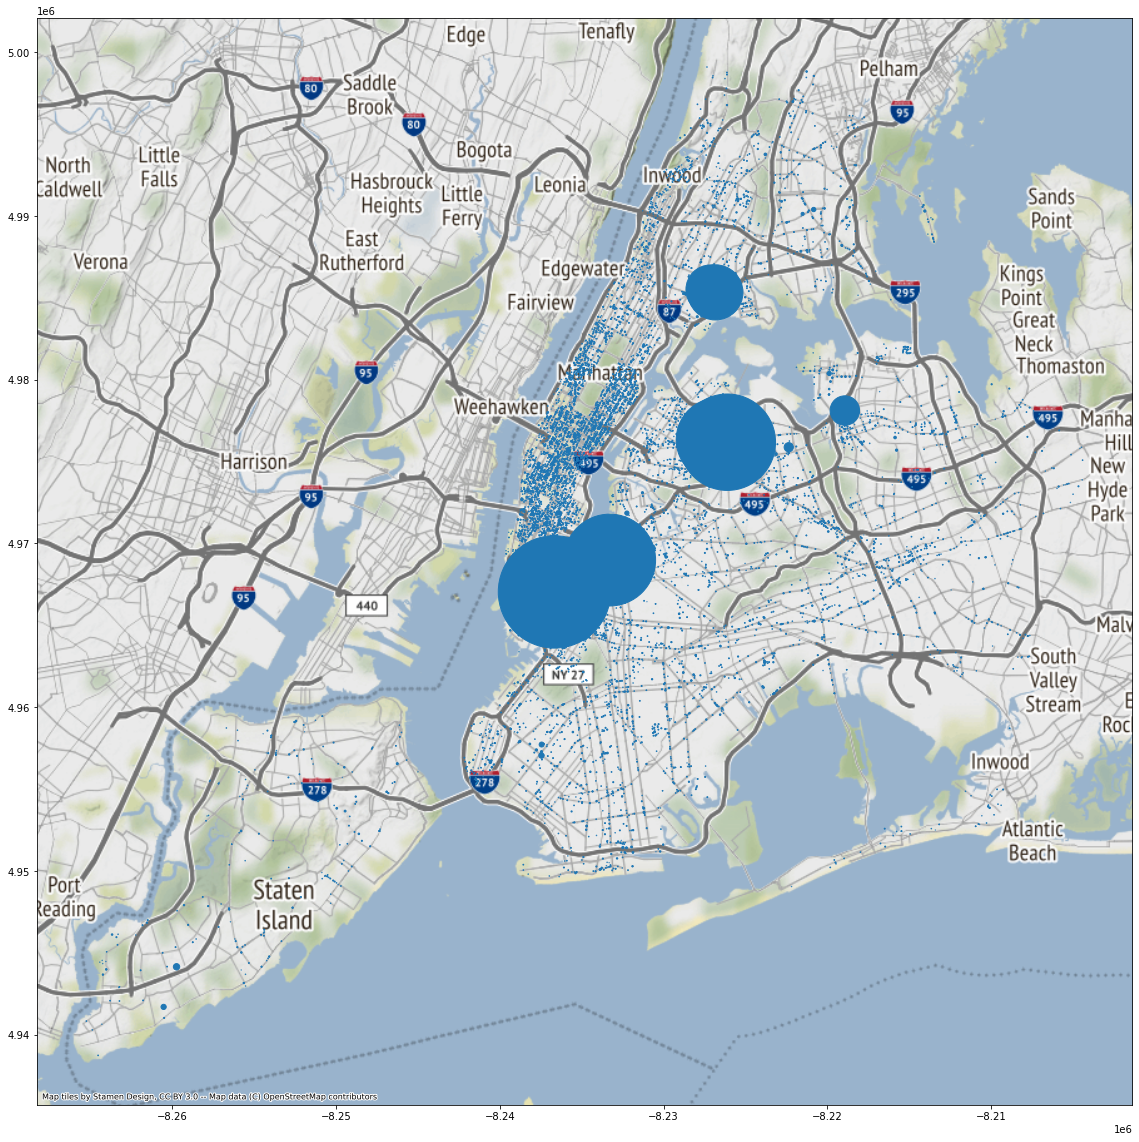

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
inner_joined_gdf.to_crs('EPSG:3857').plot(ax=ax, markersize=inner_joined_gdf['reduction_scaled']*5)
ctx.add_basemap(ax)

The two following maps use Census data to map the total value of reductions granted per Census tract, and the number of reductions given per Census tract.

Text(0.5, 1.0, 'Number of Reductions Granted Per Census Tract')

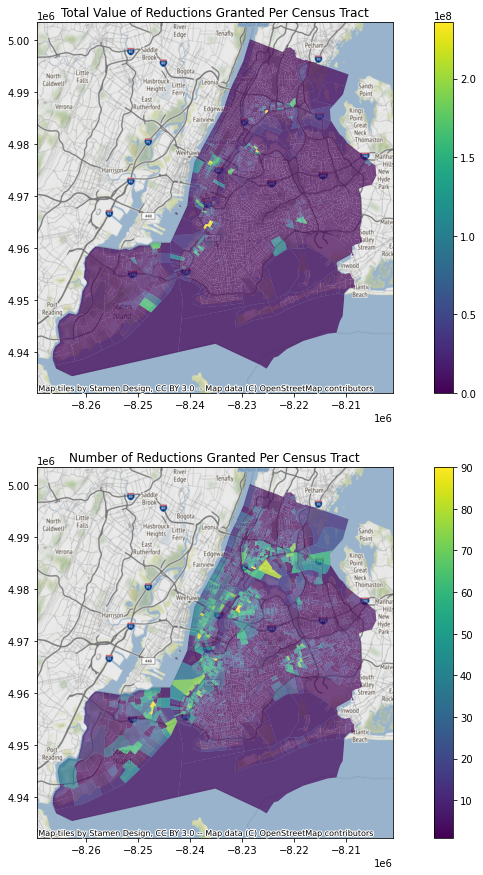

In [25]:
fig, ax = plt.subplots(2, figsize=(15,15))
ax1, ax2 = ax

censusjoined.plot(column='total_tract_reduction', ax=ax1, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax1)
ax1.set_title("Total Value of Reductions Granted Per Census Tract")

censusjoined.plot(column='number_reductions', ax=ax2, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax2)
ax2.set_title("Number of Reductions Granted Per Census Tract")

In [55]:
censusjoined.county.unique()

array(['061', '047', '005', '081', '085'], dtype=object)

In [58]:
boroughs={'code':['061', '047', '005', '081', '085'], 'borough':['MANHATTAN', 'BROOKLYN', 'BRONX', 'QUEENS', 'STATEN ISLAND']}
boroughs=pd.DataFrame(boroughs)
boroughs

code        borough
0  061      MANHATTAN
1  047       BROOKLYN
2  005          BRONX
3  081         QUEENS
4  085  STATEN ISLAND

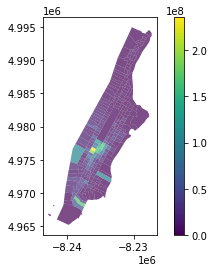

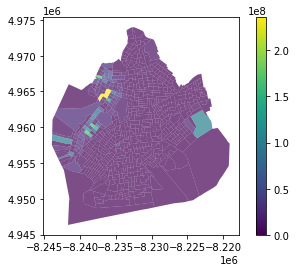

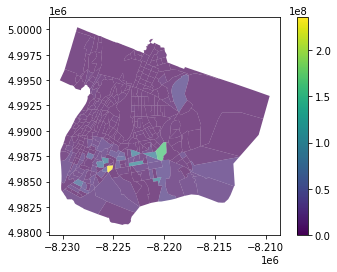

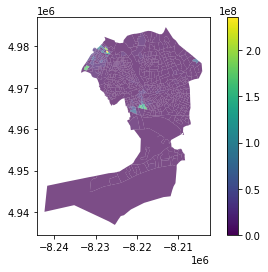

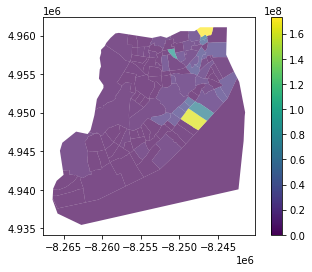

In [65]:
for code in boroughs['code']:
    #fig, ax = plt.subplots()
    censusjoined[censusjoined['county']==code].to_crs('EPSG:3857').plot(column='total_tract_reduction', missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
    #ctx.add_basemap(ax)
    #ax.set_title("Total Value of Reductions Granted Per Census Tract in"+boroughs[boroughs[borough]])

# Part 3: Machine Learning

### 1. Assessing the Total Value of Reductions in a Census Tract

We wanted to use Census information to see what variables are used to predict the total amount of reductions in a given Census tract.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'county', 'pct_renter']

yvar = 'total_tract_reduction'

df_to_fit = censusjoined[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

1578 1578
526 526


In [27]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(len(X_test), len(y_pred))

526 526


In [28]:
import numpy as np
from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))

Mean Absolute Error (MAE): 10685833.333992396
Mean Squared Error (MSE): 619192821649437.9
Root Mean Squared Error (RMSE): 24883585.385740492
Mean Absolute Percentage Error (MAPE): 2.936002076352046e+21
Explained Variance Score: 0.12823365990856883
Max Error: 225455154.38
Mean Squared Log Error: 30.086819679492862
Median Absolute Error: 3937361.59
R^2: 0.12779834231076903
Mean Poisson Deviance: 24284738.168709207


Text(0, 0.5, 'Mean decrease in impurity')

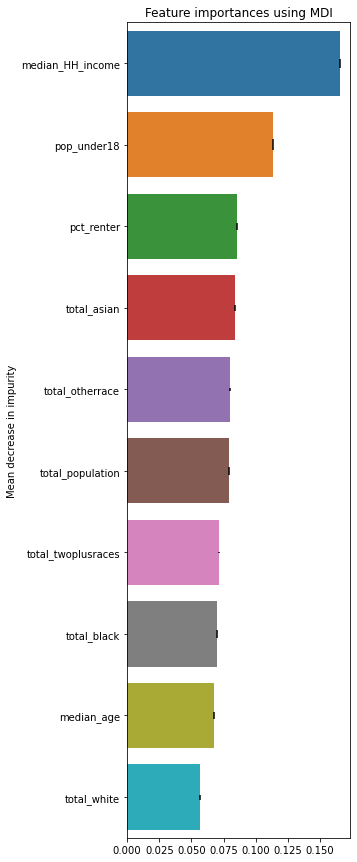

In [29]:
import seaborn as sns

importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10],yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### 2. Assessing the Total Number of Reductions in a Census Tract

We wanted to use Census information to see what variables are used to predict the number of reductions in a given Census tract.

In [30]:
xvars = ['median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'county', 'pct_renter']

yvar = 'number_reductions'

df_to_fit = censusjoined[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

1578 1578
526 526


In [31]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(len(X_test), len(y_pred))

526 526


In [32]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))

Mean Absolute Error (MAE): 10.164372623574145
Mean Squared Error (MSE): 205.2213422053232
Root Mean Squared Error (RMSE): 14.325548583049907
Mean Absolute Percentage Error (MAPE): 2.760085989193797
Explained Variance Score: 0.2309573690881852
Max Error: 75.74
Mean Squared Log Error: 1.1134000075685946
Median Absolute Error: 7.970000000000001
R^2: 0.22089513620087375
Mean Poisson Deviance: 11.844448586307228


Text(0, 0.5, 'Mean decrease in impurity')

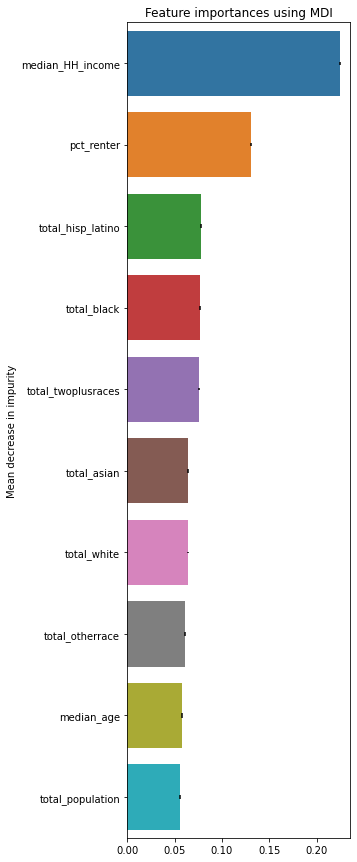

In [33]:
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10],yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### 3. Assessing what contributes to a property getting a reassessment or not

To begin, I wanted to create a column that tells us whether a property from the assesment dataset got a reduction or not. So I created a join, while removing duplicates, that would left join the actions to the valuations.

In [34]:
actions_df.index.is_unique
value_gdf.index.is_unique

False

In [35]:
#creating two new datasets just without duplicates

print('Before dropping duplicates: {}'.format(len(actions_df)))
actions_nodupl = actions_df.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(actions_nodupl)))
actions_nodupl.index.is_unique

#same thing with the other
print('Before dropping duplicates: {}'.format(len(value_gdf)))
value_nodupl = value_gdf.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(value_nodupl)))
value_nodupl.index.is_unique

Before dropping duplicates: 11773
After dropping duplicates: 9767
Before dropping duplicates: 1094727
After dropping duplicates: 1093142


True

In [36]:
# the join

NewDf_for_ML = value_nodupl.join(actions_nodupl, how='left')
print('Number of valuations: {}'.format(len(NewDf_for_ML)))
print('Number of reductions: {}'.format(NewDf_for_ML['granted_reduction_amount'].count()))

#Almost all of the reductions got added so i think this is fine

Number of valuations: 1093142
Number of reductions: 9711


In [37]:
NewDf_for_ML.granted_reduction_amount.fillna(0,inplace=True)
NewDf_for_ML['granted_reduction_amount'] = NewDf_for_ML['granted_reduction_amount'].astype(float)
NewDf_for_ML['got_reduction'] = NewDf_for_ML['granted_reduction_amount'] > 0
NewDf_for_ML.head()

geometry                                nta  \
BBB                                                                      
1-1-10   POINT (-74.01287 40.69010)        park-cemetery-etc-Manhattan   
1-1-101  POINT (-74.04534 40.68989)        park-cemetery-etc-Manhattan   
1-1-201  POINT (-74.03975 40.69883)        park-cemetery-etc-Manhattan   
1-10-1   POINT (-74.01161 40.70351)  Battery Park City-Lower Manhattan   
1-10-14  POINT (-74.01304 40.70331)  Battery Park City-Lower Manhattan   

            avland   latitude    zip stories      avtot easement valtype  \
BBB                                                                        
1-1-10   104445450  40.690096  10004    None  161206200     None   AC-TR   
1-1-101    4225950  40.689887  10004    None   12873150     None   AC-TR   
1-1-201   14972400  40.698831  10004    None  111703950     None   AC-TR   
1-10-1      607500  40.703512  10004       2    4093380     None   AC-TR   
1-10-14    7875000  40.703312  10004      30   38897100     None   AC-TR   

            exland blddepth     year taxclass   longitude bldfront bldgcl  \
BBB                                                                         
1-1-10   104445450        0  2017/18        4  -74.012866        0     Y4   
1-1-101    4225950        0  2017/18        4  -74.045337        0     P7   
1-1-201   14972400        0  2017/18        4  -74.039753        0     Z9   
1-10-1           0      191  2017/18        4  -74.011606       22     K4   
1-10-14          0      160  2017/18        4  -74.013038       58     O4   

        block     avtot2 excd1        bble               staddr exmptcl  \
BBB                                                                       
1-1-10      1  153199994  2231  1000010010   1 GOVERNORS ISLAND      X3   
1-1-101     1   11442780  4600  1000010101     1 LIBERTY ISLAND      X3   
1-1-201     1  103571640  4600  1000010201       1 ELLIS ISLAND      X3   
1-10-1     10    3331867  None  1000100001     100 BROAD STREET    None   
1-10-14    10   37711690  None  1000100014  33 WHITEHALL STREET    None   

           avland2 census_tract  lot boro ltfront    fullval   ext      bin  \
BBB                                                                           
1-1-10   104445450            5   10    1     177  358236000  None  1086389   
1-1-101    4225950            1  101    1     500   28607000  None  1090092   
1-1-201   14972400            1  201    1      63  248231000  None  1089253   
1-10-1      607500            9    1    1      22    9096399  None  1000022   
1-10-14    7875000            9   14    1      82   86438000  None  1000023   

        excd2                  owner      extot     extot2    exland2  \
BBB                                                                     
1-1-10   None  GOVERNORS ISLAND CORP  161206200  153199994  104445450   
1-1-101  None  U S GOVT LAND & BLDGS   12873150   11442780    4225950   
1-1-201  None  U S GOVT LAND & BLDGS  111703950  103571640   14972400   
1-10-1   None        FRANKLIN BH LLC          0       None       None   
1-10-14  None  BROAD FINANCIAL CENTE          0       None       None   

        community_board    borough period council_district ltdepth  \
BBB                                                                  
1-1-10              101  MANHATTAN  FINAL                1       0   
1-1-101             101  MANHATTAN  FINAL                1    1046   
1-1-201             101  MANHATTAN  FINAL                1       0   
1-10-1              101  MANHATTAN  FINAL                1     191   
1-10-14             101  MANHATTAN  FINAL                1     161   

        borough_code block_number lot_number tax_year             owner_name  \
BBB                                                                            
1-1-10           NaN          NaN        NaN      NaN                    NaN   
1-1-101          NaN          NaN        NaN      NaN                    NaN   
1-1-201          NaN          Na

In [38]:
NewDf_for_ML.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code', 'got_reduction'],
      dtype='object')

In [39]:
#converting the variables to numbers
columns=['avland', 'latitude', 'stories', 'avtot', 'exland', 'longitude', 'extot', 'fullval']
for column in columns:
    NewDf_for_ML[column]=pd.to_numeric(NewDf_for_ML[column])
NewDf_for_ML.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1093142 entries, 1-1-10 to 5-97-30
Data columns (total 49 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   geometry                  1063929 non-null  geometry
 1   nta                       1063929 non-null  object  
 2   avland                    1093142 non-null  int64   
 3   latitude                  1063929 non-null  float64 
 4   zip                       1072736 non-null  object  
 5   stories                   1046134 non-null  float64 
 6   avtot                     1093142 non-null  int64   
 7   easement                  1553 non-null     object  
 8   valtype                   1093142 non-null  object  
 9   exland                    1093142 non-null  int64   
 10  blddepth                  1093142 non-null  object  
 11  year                      1093142 non-null  object  
 12  taxclass                  1093142 non-null  object  
 13  long

In [40]:
from sklearn.model_selection import train_test_split

#we can put more interesting variables as we sort them out, but for now i used these 3
#xvars = ['avtot','avland', 'stories', 'exland', 'extot', 'fullval']

#variables added by Jacob, I think we should discuss adding one for tax class
xvars = ['avland', 'latitude', 'stories', 'avtot', 'exland', 'longitude', 'extot', 'fullval', 'boro']

yvar = 'got_reduction'

df_to_fit = NewDf_for_ML[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

782043 782043
260681 260681


In [41]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

In [42]:
print(len(X_test), len(y_pred))

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

260681 260681
[[258195    140]
 [  2229    117]]


<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

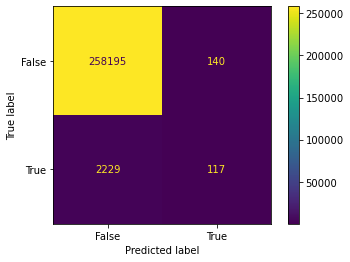

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

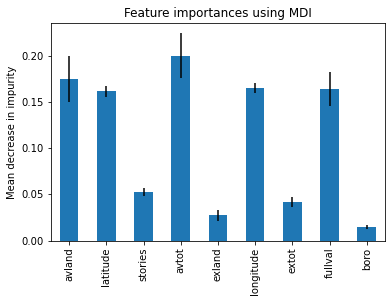

In [44]:
import numpy as np
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean decrease in impurity')

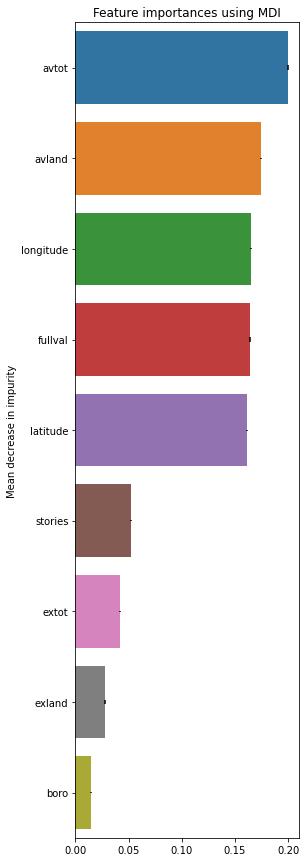

In [45]:
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10],yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

## Linear Regression

### Total Tract Reduction

In [110]:
from sklearn.linear_model import LinearRegression

xvars = ['median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'pct_renter']

yvar = 'total_tract_reduction'

df_to_fit = censusjoined[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

mlr = LinearRegression()

mlr.fit(X_train, y_train)

y_pred = mlr.predict(X_test)

coefficients=mlr.coef_

In [111]:
regression_coefficients=pd.DataFrame(coefficients, columns=['Coefficient'])
regression_coefficients['variable']=xvars
regression_coefficients

Coefficient              variable
0  -193877.803004            median_age
1    -3097.037047      total_population
2     2807.777306           total_white
3     2310.615798           total_black
4     4697.117336  total_americanindian
5     5650.651126           total_asian
6   -34879.898546        total_hawaiian
7     7318.452810       total_otherrace
8     8998.247123    total_twoplusraces
9    -1654.164755     total_hisp_latino
10   -1976.491579           pop_under18
11     207.197344      median_HH_income
12  143677.431071            pct_renter

<BarContainer object of 13 artists>

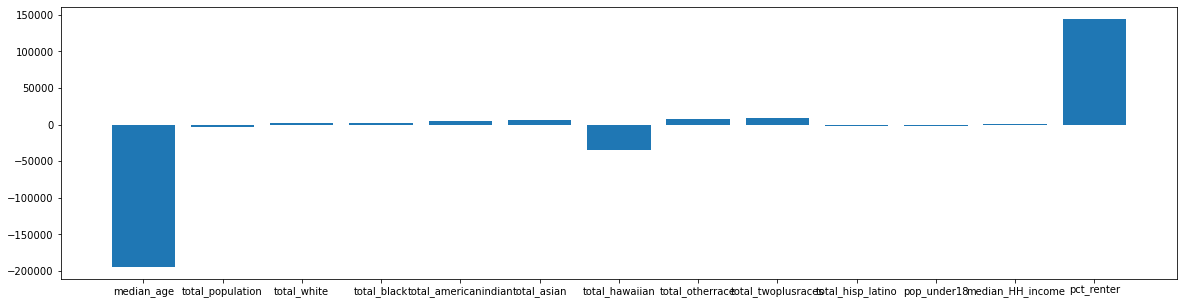

In [112]:
fig = plt.figure(figsize = (20, 5))
plt.bar(regression_coefficients['variable'], regression_coefficients['Coefficient'])

note: the median age and percent renter columns might be super big because those columns have values that are super low in comparison to the total tract reduction value (like total reduction is $1 million, while pct renter is a percent shown by a decimal), and regression just tries to find the slope that connects each variable in a linear relationship (the line of best fit).

### Number of Reductions

In [103]:
xvars = ['median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'pct_renter']

yvar = 'number_reductions'

df_to_fit = censusjoined[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

mlr = LinearRegression()

mlr.fit(X_train, y_train)

y_pred = mlr.predict(X_test)

coefficients=mlr.coef_

regression_coefficients=pd.DataFrame(coefficients, columns=['Coefficient'])
regression_coefficients['variable']=xvars
regression_coefficients

Coefficient              variable
0     -0.289922            median_age
1     -0.000177      total_population
2      0.002681           total_white
3      0.000103           total_black
4      0.015404  total_americanindian
5      0.001353           total_asian
6     -0.029143        total_hawaiian
7      0.004969       total_otherrace
8      0.004455    total_twoplusraces
9     -0.001354     total_hisp_latino
10    -0.005562           pop_under18
11     0.000169      median_HH_income
12     0.168392            pct_renter

<BarContainer object of 13 artists>

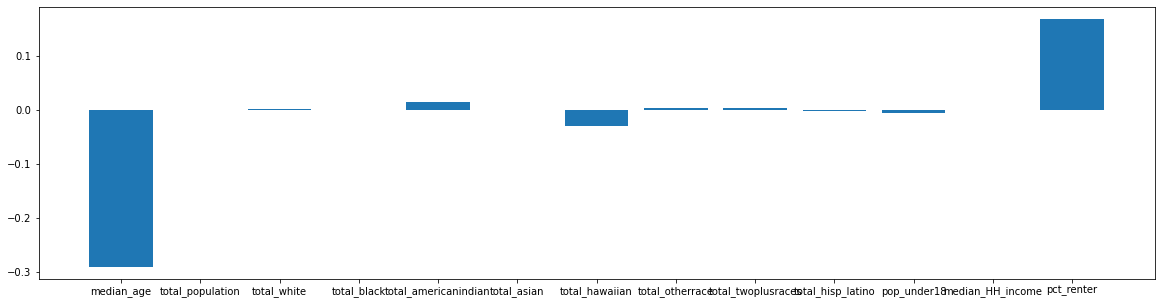

In [104]:
fig = plt.figure(figsize = (20, 5))
plt.bar(regression_coefficients['variable'], regression_coefficients['Coefficient'])